In [ ]:
import pandas as pd
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
import datetime, time
import os
import json
from dotenv import load_dotenv

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [10]:

def establish_db_connection(server, database, username, password, driver):
    connection_string = (
        f"mssql+pyodbc://{username}:{password}@{server}/{database}"
        f"?driver={driver.replace(' ', '+')}"
    )
    engine = create_engine(connection_string)

    try:
        with engine.connect() as conn:
            result = conn.execute(text("SELECT @@VERSION"))
            for row in result:
                print("Connected successfully. SQL Server version:")
                print(row[0])
            return engine
    except Exception as e:
        print("Connection failed:")
        print(e)
        return None

# Adjust to include error handling for the db connection method



In [5]:
def load_env():
    load_dotenv(dotenv_path="creds\\.env")


def SERVER_conn(input_site):

    load_env()

    # DB server
    site_server = os.getenv(input_site)
    
    
    paramz = {
        "site": os.getenv('site_server'),
        "userName": os.getenv('USER_NAME'),
        "Password": os.getenv('PASSWORD_dev-test'),
        "Driver": os.getenv("ODBC_DRIVER")
    }

    db = os.getenv(input_site)

    server_conn = establish_db_connection(
        paramz["site"],
        db, 
        paramz["userName"],     
        paramz["Password"],
        paramz["Driver"])
        
    return server_conn



def db_request(query, server_conn_str):
    if server_conn_str is None:
        raise Exception("Database connection failed. Please check your credentials and connection settings.")

    start_time = time.time()

    respo = pd.read_sql(query, server_conn_str)

    end_time = time.time()
    print(f"Query executed in {end_time - start_time:.2f} seconds")
    return respo 


In [ ]:

RO_all = "SELECT *  from Ops_tblRepairOrder where fldLastUpdated > '2023-01-1' AND fldStatus = 3 AND fldDivision IN (1)"
query_all_requests = "SELECT *  from Ops_tblRequests where fldLastUpdated > '2023-01-1' AND fldAddWorkStatus IN (100, 300, 400)" 
query_all_LabourLine = "SELECT *  from Ops_tblLabourLine where fldLastUpdated > '2023-01-1'"
query_all_PartsLine = "SELECT *  from Ops_tblPartsLine where fldLastUpdated > '2023-01-1'"

# More queries 
 

In [7]:
# search for op_codes_based_on_key_words

# select * from 
# Ops_tblOpCode2
# where fldDescription like ('%Water Pump%')

In [8]:

def pull_data_by_server(server_conn_str):
    # pull data for 
    RO_tbl = db_request(RO_all, server_conn_str)
    request_tbl = db_request(query_all_requests, server_conn_str)
    labourline_tbl = db_request(query_all_LabourLine, server_conn_str)
    partslines_tbl = db_request(query_all_PartsLine, server_conn_str)

    return RO_tbl, request_tbl, labourline_tbl, partslines_tbl


In [ ]:

# # pull data for 
# RO_tbl_vw_174 = db_request(RO_all, vw_18_db)
# request_tbl_vw_174 = db_request(query_all_requests, vw_18_db)
# labourline_tbl_vw_174 = db_request(query_all_LabourLine, vw_18_db)
# partslines_tbl_vw_174 = db_request(query_all_PartsLine, vw_18_db)


Query executed in 3.17 seconds
Query executed in 25.35 seconds
Query executed in 10.27 seconds
Query executed in 28.09 seconds


In [ ]:

# function to drop empty columns
def drop_empty_columns(df):
    df_cleaning = df.copy()
    # drop empty columns - must all empty
    df_cleaning = df_cleaning.dropna(axis=1, how='all')
    
    return df_cleaning
 

In [13]:
# function to filter columns
def filter_for_essential_columns(df, essential_cols):
    df_selected = df[essential_cols].copy()
    return df_selected

In [71]:
# Defined essential columns for each table

essential_columns_request_tbl = ['fldId', 'fldWorkItemRef', 'fldSequence', 'fldDescription',
       'fldRequestCodeRef', 'fldRequestCode', 'fldRequestedTime', 'fldOrderNumber',
        'fldLastUpdated']


essential_cols_labourline_tbl = ['fldID', 'fldRequestRef', 'fldOpCodeRef',
       'fldActualHours', 'fldSoldHours', 'fldDescription',
       'fldAddedDate']

essential_cols_partlines_tbl = ['fldID', 'fldRequestRef', 'fldSequence', 'fldPartNumber', 'fldPartDesc',
       'fldRequested', 'fldShipped', 'fldOrderType', 'fldDateAdded']


essential_cols_RO_tbl = ['fldId', 'fldContactRef', 'fldVehicleRef', 'fldDateOpened',
       'fldDateClosed'
       ]
       
  

In [15]:

def clean_datset(df, tbl_type):
    df_dropped_empty_cols = drop_empty_columns(df)

    if tbl_type == "request":
        df_filtered = filter_for_essential_columns(df_dropped_empty_cols, essential_columns_request_tbl)
    
    elif tbl_type == "labourline":
        df_filtered = filter_for_essential_columns(df_dropped_empty_cols, essential_cols_labourline_tbl)

    elif tbl_type == "partslines":
        df_filtered = filter_for_essential_columns(df_dropped_empty_cols, essential_cols_partlines_tbl)

    elif tbl_type == "RO_tbl":
        df_filtered = filter_for_essential_columns(df_dropped_empty_cols, essential_cols_RO_tbl)
        # remove
        
    return df_filtered
 

In [16]:

# request_tbl_vw_174 = clean_datset(request_tbl_vw_174, tbl_type="request")
# labor_tbl_vw_174 = clean_datset(labourline_tbl_vw_174, tbl_type="labourline")
# parts_tbl_vw_174 = clean_datset(partslines_tbl_vw_174, tbl_type="partslines")
# RO_tbl_vw_174 = clean_datset(RO_tbl_vw_174, tbl_type="RO_tbl")

#### Find a list of labour and parts for the following repair jobs 

- water pump 
- Timing belt
- Electrical - exterior lights


In [182]:
def search_columns_for_keyword(df, keyword, column):
    if (column not in df.columns) or column=="":
        raise ValueError(f"Column '{column}' does not exist in the DataFrame.")
    filtered_df = df[df[column].str.contains(keyword, case=False, na=False)]
    return filtered_df

def get_top_ten_opcodes(df):
    top_ten = df["fldRequestCode"].value_counts().head(20)
    return top_ten

def search_request_by_opcode(df, opcode):
    search_result = df[df["fldRequestCode"]== opcode]
    
    return search_result

def search_request_by_list_of_opcodes(df, opcode_list):
    search_result = df[df["fldRequestCode"].isin(opcode_list)]
    
    return search_result



def part_items_metrics(parts_df):

    uniq_item_by_description = set(parts_df['fldPartDesc'].unique())
    metrics = pd.DataFrame(columns = ['partDesc','#UniqParts','#Qty','uniq_partNumbers'])

    for desc in uniq_item_by_description:
        item_count = len(parts_df[parts_df['fldPartDesc'] == desc]) 
        total_units = parts_df[parts_df['fldPartDesc'] == desc]['fldRequested'].sum()
        uniq_partNumbers = parts_df[parts_df['fldPartDesc'] == desc]['fldPartNumber'].unique().tolist()
        new_row = {
                    'partDesc': desc, 
                    '#UniqParts': item_count, 
                    '#Qty': total_units,
                    'uniq_partNumbers': uniq_partNumbers
                    }
        
        # metrics = pd.DataFrame(columns = ['partDesc','#UniqParts','#Qty','uniq_partNumbers'])
        
        new_row_df = pd.DataFrame([new_row]).reindex(columns=metrics.columns)
        metrics = pd.concat([metrics, new_row_df], ignore_index=True)
    return metrics




# def parts_summary(parts_tbl_df, total_req_count):
#     # Count occurrences of each unique part
#     part_counts = parts_tbl_df['fldPartDesc'].value_counts()

#     # Calculate percentage occurrence
#     metrics = (part_counts / total_req_count * 100).reset_index()
#     metrics.columns = ['Part', '#Percentage']

#     # Sort for readability
#     metrics = metrics.sort_values(by='#Percentage', ascending=False)

#     # Optional: Round percentages
#     metrics['#Percentage'] = metrics['#Percentage'].round(2)

#     display(metrics)
#     return metrics


def parts_summary(parts_tbl_df, total_req_count):
    
    parts_tbl_df.loc[parts_tbl_df["fldPartDesc"].notna(), "fldPartDesc"] = (
        parts_tbl_df.loc[parts_tbl_df["fldPartDesc"].notna(), "fldPartDesc"].str.upper()
    )

    
    metrics = (
        parts_tbl_df[['fldPartDesc', 'fldRequestRef']]
        .drop_duplicates()  # Ensures each part-request pair is counted once
        .groupby('fldPartDesc')
        .size()
        .reset_index(name='Count')
    )

    metrics['%Occurrence'] = (metrics['Count'] / total_req_count) * 100
    metrics = metrics[['fldPartDesc', '%Occurrence']].rename(columns={'fldPartDesc': 'Part'})
    metrics['%Occurrence'] = metrics['%Occurrence'].round(2)

    # Sort by percentage ascending
    metrics = metrics.sort_values(by='%Occurrence', ascending=False)
    metrics = metrics.reset_index(drop=True)
    

    display(metrics)





def search_parts_and_labour_by_req_id(labor, parts, req_id):

    if "fldRequestRef" not in labor.columns or "fldRequestRef" not in parts.columns:
        raise ValueError("The required column 'fldRequestRef' does not exist in one of the DataFrames.")
    
    labor_result = labor[labor["fldRequestRef"]== req_id]
    parts_result = parts[parts["fldRequestRef"]== req_id]
        
    print(f"Labour items for Request ID {req_id}:")
    display(labor_result)
    print(f"Parts items for Request ID {req_id}:")
    display(part_items_metrics(parts_result))
    

In [262]:

def get_valid_op_codes_by_keyword(db_conn, key_word):
    query = "select * from  Ops_tblOpCode2 where fldDescription like ('%"+key_word+"%')"
    search_result = db_request(query, db_conn)

    return search_result["fldCode"].values.tolist()


def get_all_op_codes(db_conn):
    query = "select * from  Ops_tblOpCode2"
    search_result = db_request(query, db_conn)

    return search_result


In [19]:

def clean_data(RO_tbl, request_tbl, labourline_tbl, partslines_tbl):
    RO_tbl_cleaned = clean_datset(RO_tbl, tbl_type="RO_tbl")
    request_tbl_cleaned = clean_datset(request_tbl, tbl_type="request")
    labourline_tbl_cleaned = clean_datset(labourline_tbl, tbl_type="labourline")
    partslines_tbl_cleaned = clean_datset(partslines_tbl, tbl_type="partslines")

    return RO_tbl_cleaned, request_tbl_cleaned, labourline_tbl_cleaned, partslines_tbl_cleaned


In [ ]:
def parts_analysis(part_items, tracker_count_part_item_once_per_job, parts_summary_df):
    for index, row in part_items.iterrows():
            part_number = row["fldPartNumber"]
            part_desc = row["fldPartDesc"]

            
            if part_number in parts_summary_df["Part Number"].values and part_number not in tracker_count_part_item_once_per_job:
                parts_summary_df.loc[parts_summary_df["Part Number"] == part_number, "Occurrence_count"] += 1
                tracker_count_part_item_once_per_job.add(part_number)
            else:
                new_row = {
                    "Part Number": part_number,
                    "Part Description": part_desc,
                    "Occurrence_count": 1
                }
                parts_summary_df = pd.concat([parts_summary_df, pd.DataFrame([new_row])], ignore_index=True) 
                tracker_count_part_item_once_per_job.add(part_number)
                parts_summary_df.sort_values(by="Occurrence_count", ascending=False, inplace=True)

    return parts_summary_df, tracker_count_part_item_once_per_job

In [37]:
def labour_items_analysis(labour_items, tracker_count_labour_item_once_par_job, labour_summary_df):
    for index, row in labour_items.iterrows():
            op_code = row["fldOpCodeRef"]
            labour_desc = row["fldDescription"]

            if op_code in labour_summary_df["fldOpCodeRef"].values and op_code not in tracker_count_labour_item_once_par_job:
                labour_summary_df.loc[labour_summary_df["fldOpCodeRef"] == op_code, "Occurrence_count"] += 1
                tracker_count_labour_item_once_par_job.add(op_code)
            else:
                new_row = {
                    "fldOpCodeRef": op_code,
                    "fldDescription": labour_desc,
                    "Occurrence_count": 1
                }
                labour_summary_df = pd.concat([labour_summary_df, pd.DataFrame([new_row])] , ignore_index=True )
                tracker_count_labour_item_once_par_job.add(op_code)
                labour_summary_df.sort_values(by="Occurrence_count", ascending=False, inplace=True)  
    return labour_summary_df, tracker_count_labour_item_once_par_job

In [72]:
def requestsLines_analysis(req_id, part_items, labour_items, filtered_requests_df, request_summary_df):
    
    new_row = {
            "Request ID": req_id,
            "Description": filtered_requests_df[filtered_requests_df["fldId"] == req_id ]["fldDescription"].values[0],
            "fldRequestCode": filtered_requests_df[filtered_requests_df["fldId"] == req_id ]["fldRequestCode"].values[0],
            "#_PartItems": len(part_items),
            "#_LaborItems": len(labour_items)
            }

    request_summary_df = pd.concat([request_summary_df, pd.DataFrame([new_row])], ignore_index=True )
    request_summary_df.sort_values(by="#_PartItems", ascending=False, inplace=True)
    
    return request_summary_df

In [ ]:

# def maximus(db_conn, key_wrd, RO_tbl, request_tbl, labourline_tbl, partslines_tbl):

def run_analysis(db_conn, key_wrd, labourline_tbl, partslines_tbl, request_tbl):

    opcodes_list = get_valid_op_codes_by_keyword(db_conn, key_wrd)

    if opcodes_list == []:
        raise ValueError(f"No opcodes found for keyword '{key_wrd}'")

    filtered_requests_df = search_request_by_list_of_opcodes(request_tbl, opcodes_list)

    # search from labour line and part line where fldRequestRef in filtered_requests_df['fldId']
    filtered_labour_df = labourline_tbl[labourline_tbl["fldRequestRef"].isin(filtered_requests_df['fldId'])]
    filtered_parts_df = partslines_tbl[partslines_tbl["fldRequestRef"].isin(filtered_requests_df['fldId'])]


    # parts_summary_df=[]
    # labour_summary_df=[]
    # request_summary_df=[]

    parts_summary_df = pd.DataFrame(columns=["Part Number", "Part Description", "Occurrence_count"])
    labour_summary_df = pd.DataFrame(columns=["fldOpCodeRef", "fldDescription", "Occurrence_count"])
    requestLine_summary_df = pd.DataFrame(columns=["Request ID", "Description","fldRequestCode", "#_PartItems", "#_LaborItems"])
 
    for items in filtered_requests_df['fldId'].values:
        req_id = items

        tracker_count_part_item_once_per_job = set()
        tracker_count_labour_item_once_par_job = set()
        

    # print(filtered_requests_df[filtered_requests_df["fldId"] == req_id ]["fldDescription"])

        # search for all parts and labour lines for this req_id
        part_items = filtered_parts_df[filtered_parts_df["fldRequestRef"]== req_id]
        labour_items = filtered_labour_df[filtered_labour_df["fldRequestRef"]==req_id]

        requestLine_summary_df = requestsLines_analysis(req_id, part_items, labour_items, filtered_requests_df, requestLine_summary_df)

        if not part_items.empty:
            parts_summary_df, tracker_count_part_item_once_per_job = parts_analysis(
                                                                                    part_items=part_items, 
                                                                                    tracker_count_part_item_once_per_job = tracker_count_part_item_once_per_job, 
                                                                                    parts_summary_df = parts_summary_df
                                                                                    )


        if not labour_items.empty:
            labour_summary_df, tracker_count_labour_item_once_par_job = labour_items_analysis(
                                                                                        labour_items=labour_items, 
                                                                                        tracker_count_labour_item_once_par_job=tracker_count_labour_item_once_par_job, 
                                                                                        labour_summary_df=labour_summary_df
                                                                                        )                                                        


    return requestLine_summary_df, parts_summary_df, labour_summary_df, filtered_parts_df

In [235]:
def plot_stats(requestLine_summary_df):

    parts_stats =  (
    requestLine_summary_df["#_PartItems"]
    .value_counts()
    .reset_index()
    .rename(columns={'index': '#_PartItems', '#_PartItems': '#Parts'})
    )

    labour_stats =  (
        requestLine_summary_df["#_LaborItems"]
        .value_counts()
        .reset_index()
        .rename(columns={'index': '#_LaborItems', '#_LaborItems': '#labour'})
    )

    # Sort for better visualization
    parts_stats = parts_stats.sort_values(by='#Parts').reset_index(drop=True)
    labour_stats = labour_stats.sort_values(by='#labour').reset_index(drop=True)




    # Compute stats for Parts
    mean_parts = parts_stats['#Parts'].mean()
    median_parts = parts_stats['#Parts'].median()
    mode_parts = parts_stats['#Parts'].mode()[0]

    # Compute stats for Labour
    mean_labour = labour_stats['#labour'].mean()
    median_labour = labour_stats['#labour'].median()
    mode_labour = labour_stats['#labour'].mode()[0]


    # Plot Parts line
    plt.plot(parts_stats['#Parts'], parts_stats['count'], color='blue', marker='o', label='Parts')

    # Plot Labour line
    plt.plot(labour_stats['#labour'], labour_stats['count'], color='green', marker='o', label='Labour')



    # Add reference lines for mean
    plt.axvline(mean_parts, color='blue', linestyle='--', alpha=0.5, label=f'Parts Mean: {mean_parts:.2f}')
    plt.axvline(mean_labour, color='green', linestyle='--', alpha=0.5, label=f'Labour Mean: {mean_labour:.2f}')


    # Annotate median and mode
    plt.text(parts_stats['#Parts'].max(), median_parts, f'Median: {median_parts}', color='blue')
    plt.text(parts_stats['#Parts'].max(), mode_parts, f'Mode: {mode_parts}', color='blue')
    plt.text(labour_stats['#labour'].max(), median_labour, f'Median: {median_labour}', color='green')
    plt.text(labour_stats['#labour'].max(), mode_labour, f'Mode: {mode_labour}', color='green')


    # Labels and title
    plt.xlabel('Item Count')
    plt.ylabel('Frequency')
    plt.title('Parts vs Labour Items with Summary Stats')
    plt.legend()
    plt.grid(True)
    plt.show()

In [277]:
db_server = "DB_server_130"
# key_wrd = "Water Pump Replace"
key_wrd = "Replace Water Pump"
server_conn = SERVER_conn(db_server)

Connected successfully. SQL Server version:
Microsoft SQL Server 2022 (RTM-CU21-GDR) (KB5068406) - 16.0.4222.2 (X64) 
	Oct  3 2025 16:55:17 
	Copyright (C) 2022 Microsoft Corporation
	Developer Edition (64-bit) on Windows Server 2022 Standard 10.0 <X64> (Build 20348: )



In [269]:
all_opcode_df = get_all_op_codes(server_conn)

# all_opcode_df = get_valid_op_codes_by_keyword(server_conn, key_wrd)


Query executed in 0.29 seconds


In [278]:




RO_tbl, request_tbl, labourline_tbl, partslines_tbl = pull_data_by_server(server_conn)
RO_tbl, request_tbl, labourline_tbl, partslines_tbl = clean_data(RO_tbl, request_tbl, labourline_tbl, partslines_tbl)


Query executed in 7.47 seconds
Query executed in 64.59 seconds
Query executed in 26.20 seconds
Query executed in 45.95 seconds


In [148]:

requestLine_summary_df, parts_summary_df, labour_summary_df, filtered_parts = run_analysis(server_conn, key_wrd, labourline_tbl, partslines_tbl, request_tbl)
 

Query executed in 0.03 seconds


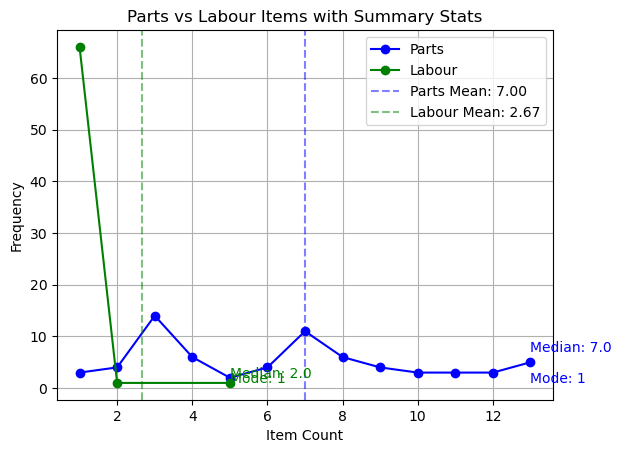

In [237]:
plot_stats(requestLine_summary_df)

7.0

In [248]:
# Labour and Parts by Request ID 

# req_id="361C71BE-99B9-4CF8-8FA4-2211554A56EA"
# req_id="2B2EB6DA-0BB5-49D4-9F17-43A411BFE755" 
req_id = "3884CA2E-30E8-4CD5-9CC0-5BB0844B8F5C"

search_parts_and_labour_by_req_id(labor= labourline_tbl, parts= partslines_tbl, req_id= req_id)

# Perc occurrence for each product



Labour items for Request ID 3884CA2E-30E8-4CD5-9CC0-5BB0844B8F5C:


,fldID,fldRequestRef,fldOpCodeRef,fldActualHours,fldSoldHours,fldDescription,fldAddedDate,fldLastUpdated
101100,9BFB2748-066D-4ED2-9AA5-A6474F9830DE,3884CA2E-30E8-4CD5-9CC0-5BB0844B8F5C,E2161A97-E919-43C9-8D0B-A645A60E3C1D,2.29,0.0,COVER REMOVED,2025-06-04,2025-07-09 15:16:37.093
101101,D015AC0D-3B19-4443-87AE-D09C32233503,3884CA2E-30E8-4CD5-9CC0-5BB0844B8F5C,00BCF2B1-7270-47E4-B667-FEEEB4011747,0.00,0.0,COOLANT DRAINED,2025-06-05,2025-07-09 15:16:37.093
101102,7AA45C1B-F99B-4C34-B253-84257B196B12,3884CA2E-30E8-4CD5-9CC0-5BB0844B8F5C,C22F4012-D88D-46A6-A434-B17CFCA2D797,0.00,0.0,COOLANT PUMP\r\n,2025-06-05,2025-07-09 15:16:37.093
101103,00B1B326-F15F-4F03-8328-09F254C23452,3884CA2E-30E8-4CD5-9CC0-5BB0844B8F5C,B7ED7A5C-4DBB-4842-A5E2-E07822C76BB0,0.00,0.0,TOOTHBELT,2025-06-05,2025-07-09 15:16:37.093
101104,9E375C98-6CDA-4782-A509-142B707D42C5,3884CA2E-30E8-4CD5-9CC0-5BB0844B8F5C,290AEB1B-B97E-4D7A-A022-4A81B14B5319,0.00,0.0,GFF FOR TSB:,2025-06-05,2025-07-09 15:16:37.093


Parts items for Request ID 3884CA2E-30E8-4CD5-9CC0-5BB0844B8F5C:


,partDesc,#UniqParts,#Qty,uniq_partNumbers
0,WATER PUMP,1,1.0,[06L 121 012 L]
1,BOLT,1,1.0,[WHT 001 163 B]


In [249]:
all_filtered_req_count = len(filtered_parts['fldRequestRef'].unique())

print(f"Parts % occurrence in a {key_wrd} job")
parts_summary(parts_tbl_df = filtered_parts, total_req_count = all_filtered_req_count)

Parts % occurrence in a Water Pump Replace job


,Part,%Occurrence
0,WATER PUMP,82.35
1,COOLANT,82.35
2,SCREW,67.65
3,BOLT,58.82
4,TOOTH BELT,27.94
5,GASKET,26.47
6,SEAL RING,22.06
7,REPAIR KIT,11.76
8,REGULATOR,8.82
9,THERMOSTAT,8.82


In [72]:
# create a summary df that summarizes the data
# list all the unique requests from req table and save them in a df
# Go through the parts and labour tables and count the number of part and labour items associated with that request id
# this will provide insight on the difference between the number of items suggested for the job


# create a summary of occurrence of part and labour items
# by partNumber, count how many time each part number appears and rank them by how often they appear 



Analysis for Ford Site 130

In [326]:
db_server_130 = "DB_server_130"
# key_wrd = "Water Pump Replace"
key_wrd_130 = "Replace Water Pump"
server_conn_db_130 = SERVER_conn(db_server)

Connected successfully. SQL Server version:
Microsoft SQL Server 2022 (RTM-CU21-GDR) (KB5068406) - 16.0.4222.2 (X64) 
	Oct  3 2025 16:55:17 
	Copyright (C) 2022 Microsoft Corporation
	Developer Edition (64-bit) on Windows Server 2022 Standard 10.0 <X64> (Build 20348: )



In [ ]:

RO_tbl_db_130, request_tbl_db_130, labourline_tbl_db_130, partslines_tbl_db_130 = pull_data_by_server(server_conn_db_130)
RO_tbl_db_130, request_tbl_db_130, labourline_tbl_db_130, partslines_tbl_db_130 = clean_data(RO_tbl_db_130, request_tbl_db_130, labourline_tbl_db_130, partslines_tbl_db_130)



In [ ]:


requestLine_summary_df_db130, parts_summary_df_db130, labour_summary_df_db130, filtered_parts_db130 = run_analysis(server_conn, key_wrd, labourline_tbl, partslines_tbl, request_tbl)



Query executed in 0.03 seconds
1


In [ ]:

all_opcode_df_130 = get_all_op_codes(server_conn_db_130)

# all_opcode_df_130 = get_valid_op_codes_by_keyword(server_conn, key_wrd)
 

Query executed in 0.15 seconds


In [333]:
all_opcode_df_130[all_opcode_df_130["fldDescription"].str.contains("water pump", case=False)][["fldDescription", "fldCode"]]
all_opcode_df_130[all_opcode_df_130["fldDescription"].str.contains("water pump", case=False)]["fldDescription"].unique()

array(['Water Pump or Gasket - Remove and Install or Replace ',
       'Water Pump, Electric Motor Assembly - Replace ENGINE',
       'Water Pump or Gasket - Remove and Install or Replace 6.7L DI T',
       'Water Pump or Gasket - Remove and Install or Replace 3.5L GTDI,SVT RAPTOR',
       'Water Pump or Gasket - Remove and Install or Replace 1.5L DRAG',
       'Water Pump, Electric Motor Assembly - Replace 2.0L GTDI',
       'REPLACE WATER PUMP',
       'Water Pump or Gasket - Remove and Install or Replace 5.0L TIVCT'],
      dtype=object)

In [332]:
request_tbl[request_tbl["fldRequestCode"].isin(
    all_opcode_df[all_opcode_df["fldDescription"].str.contains("water pump", case=False)]["fldCode"].tolist()
)]["fldRequestCode"].value_counts()

fldRequestCode
8419AB     9
8501A      7
8501AD     5
8501AXQ    4
8501AA     3
8419A      3
Name: count, dtype: int64

In [ ]:
request_tbl

In [282]:
plot_stats(requestLine_summary_df_db130)

KeyError: 0

In [ ]:
# Labour and Parts by Request ID 

# req_id="361C71BE-99B9-4CF8-8FA4-2211554A56EA"
# req_id="2B2EB6DA-0BB5-49D4-9F17-43A411BFE755" 
req_id = "3884CA2E-30E8-4CD5-9CC0-5BB0844B8F5C"

search_parts_and_labour_by_req_id(labor= labourline_tbl, parts= partslines_tbl, req_id= req_id)

# Perc occurrence for each product

In [ ]:
all_filtered_req_count_db130 = len(filtered_parts_db130['fldRequestRef'].unique())

print(f"Parts % occurrence in a {key_wrd} job")
parts_summary(parts_tbl_df = filtered_parts_db130, total_req_count = all_filtered_req_count_db130)
